# Development version 8.5.21:1900

In [4]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak
# It is assumed that the structure of the data is coherent.

def findPeakIndices(data):

# each peak in 'data' starts and ends with a zero
# so that there are two zeros between each peak
# =============================================

    n = int(round(sum(data.iloc[:,1] == 0)/2)+1) # n is just the upper limit for the number of peaks
    indices = np.zeros([n,2], dtype="uint32")    # true n may be lower

    ii = 0                                       # index for indices
    indices[ii,0] = 0
    i = 1
    while i < len(data):
        if data.iloc[i,1] == 0:     
            if (i+1) == len(data):
                indices[ii,1] = i
            elif data.iloc[i+1,1] == 0:
                indices[ii,1] = i
                ii = ii+1
                i = i+1
                indices[ii,0] = i
        i = i+1
        
# n may be too large, because there are sometimes single zeros within peaks
# therefore, extra indices are cut out
    indices = indices[0:ii+1,:]
    return indices

# KO 6.4. zeros in the beginning and end are now included in indexed peaks
# Another way to save the indices could also be used: 
# add 1 to every indices[ii,0]
# minus 1 from every indices[ii,1]

In [5]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak.iloc[:,0], weights=peak.iloc[:,1])  # painotettu keskiarvo

    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc =  lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]

    out = leastsq(errfunc, init, args=(peak.iloc[:,0], peak.iloc[:,1]))                 
    c = out[0]
    return sigma, c[1]

# Modified 3-5.4. by KO

In [7]:
import numpy as np

def getAllMeans(data):
    indices = findPeakIndices(data)
    peakAreas = getAllAreas(data,indices)
    peakSkews = getAllSkews(data,indices)

    n = len(indices)  
    means = np.zeros(n)
    sigmas = np.zeros(n)
    lefts = np.zeros(n)
    rights = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        sigmas[i], means[i] = getMean(peak)
        lefts[i] = indices[i,0]
        rights[i] = indices[i,1]

    return sigmas, means, peakAreas, peakSkews, lefts, rights


In [6]:
import numpy as np

# Get all peak means for the data
def XgetAllMeans(peaks):    # NOT IN USE
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

# This JKo method is not implemented!

## getArea

Actual area of the peak is calculated from the peak histogram.

In [161]:
import numpy as np

def getArea(peak):
    zum = 0         # m/z channels have different widths, but we count intensities
    for i in range(1,len(peak)-1):
        zum = zum + peak.iloc[i,1]

        #
# After all it was realized that the next line does not give proper counts
#
#    zum = zum * (peak.iloc[len(peak)-1,0]-peak.iloc[1,0])/(len(peak)-2)
    return zum

# KO 4.4. & 8.5

In [9]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getArea(peak)
#    print("all areas ok")
    return areas

# KO 4.4.

In [10]:
import numpy as np
# Pandas has its own skew method.
import pandas as pd

def getSkew(peak):
    dta=peak.iloc[:,1]
    skw = dta.skew(axis = 0)
    return skw

# KO 5.4.

In [11]:
import pandas as pd
import numpy as np

def getAllSkews(data, indices):

    n = len(indices)
    skews = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        skews[i] = getSkew(peak)

    return skews

# KO 9.3.

In [156]:
import pandas as pd
import numpy as np

def getPeak(i, peaklist, interest):
    ix = 0
    # ion index i is here changed to array index ix 
    for j in range(len(peaklist)):
        if peaklist.iloc[j,9] == i:
            ix = j
    if interest:
        print("Peak of interest: ",peaklist.iloc[ix,0])

    left = int(peaklist.iloc[ix,7])
    right = int(peaklist.iloc[ix,8])
    peak = data[left:right+1]
#    print("L R: ",left,right)    
#    print(peak)  # To show tha actual peak data in numbers
    return ix, peak

# KO 5.4.

## addGaussians

Gaussian model from lmfit library is fitted on each peak.

Center, sigma, and fwhm are saved in the peaklist dataframe.

In [416]:
import pandas as pd
import numpy as np
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel
#from lmfit import fit_report

def addGaussians(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,9]                                 #  for the INDEX column
        ix, peak = getPeak(index,peaklist, False)
        df = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        df['index'] = np.arange(cc).reshape(cc,1)
        df['x'] = peak.iloc[:,0]
        df['y'] = peak.iloc[:,1]
        df.set_index('index', inplace = True)

        model = GaussianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerGv = param.value
            if parname == 'sigma':
                sigmaGv = param.value
            if parname == 'fwhm':
                fwhmGv = param.value
# The height part only for the single spectrum analysis for now
#            if parname == 'height':
#                heightGv = param.value
                
        peaklist.iloc[i,10] = centerGv
        peaklist.iloc[i,11] = sigmaGv
        peaklist.iloc[i,12] = fwhmGv

        
        
        model = LorentzianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerLv = param.value
            if parname == 'sigma':
                sigmaLv = param.value
            if parname == 'fwhm':
                fwhmLv = param.value
                
        peaklist.iloc[i,13] = centerLv
        peaklist.iloc[i,14] = sigmaLv
        peaklist.iloc[i,15] = fwhmLv
        
#        peaklist.iloc[i,16] = heightGv
        
        
#        model = VoigtModel()
#        pars = model.guess(df['y'], x=df['x'])
#        pars['gamma'].set(value=0.7, vary=True, expr='')
#        result  = model.fit(df['y'], pars, x=df['x'])
        
#        for parname, param in result.pars.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
#            if parname == 'center':
#                centerVv = param.value
#            if parname == 'sigma':
#                sigmaVv = param.value
#            if parname == 'fwhm':
#                fwhmVv = param.value
                
#        peaklist.iloc[i,16] = centerVv
#        peaklist.iloc[i,17] = sigmaVv
#        peaklist.iloc[i,18] = fwhmVv
        
# KO 6.5. rewritten

## addVoigt

Voigt model from lmfit library is fitted on each peak.

Center, sigma, and fwhm are saved in the peaklist dataframe

Some problem with this when trying to do this again. Skip this.

In [14]:
import pandas as pd
import numpy as np
from lmfit.models import VoigtModel
from lmfit import fit_report

def addVoigt(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,9]                                 #  for the INDEX column

        ix, peak = getPeak(index,peaklist, False)
        dfd = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        dfd['index'] = np.arange(cc).reshape(cc,1)
        dfd['x'] = peak.iloc[:,0]
        dfd['y'] = peak.iloc[:,1]
        dfd.set_index('index', inplace = True)

        print(dfd)
        print(dfd.dtypes)

        model = VoigtModel()
        params = model.guess(dfd['y'], x=dfd['x'])
        print(params)
        result = model.fit(dfd['y'], params, x=dfd['x'])
        print(result)


#print(out.fit_report(min_correl=0.25))
        
#Parameters([('amplitude', <Parameter 'amplitude', value=509.59811179953465, bounds=[-inf:inf]>), 
#            ('center', <Parameter 'center', value=61.98837236406859, bounds=[-inf:inf]>), 
#            ('sigma', <Parameter 'sigma', value=1.8807115455565794e-05, bounds=[0.0:inf]>), 

        
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerVv = param.value
            if parname == 'sigma':
                sigmaVv = param.value
            if parname == 'fwhm':
                fwhmVv = param.value
                
        peaklist.iloc[i,16] = centerVv
        peaklist.iloc[i,17] = sigmaVv
        peaklist.iloc[i,18] = fwhmVv
        
# KO 6.5.

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plotPeak(i, peaklist):

    ix, peak = getPeak(i, peaklist, True)
    
    plt.plot(peak.iloc[:,0],peak.iloc[:,1])
    plt.vlines(peaklist.iloc[ix,2],0,max(peak.iloc[:,1]))
    plt.vlines(peaklist.iloc[ix,1],0,max(peak.iloc[:,1]), color = "green")

    plt.legend(["Data","Mean from data","True mean"])
    plt.title(peaklist.iloc[ix,0])
    plt.show()
    
# KO 5.4.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel

def plotGaussian(i, peaklist):
    
    ix, peak = getPeak(i, peaklist, True)  
    
# read the data into a pandas DataFrame, and use the ‘x’ and ‘y’ columns:
# Sata is already in such a dataframe
# dframe = pd.read_csv('peak.csv')

    df = pd.DataFrame(peak, columns = ['x','y'])
    cc = len(peak.iloc[:,0])
    df['index'] = np.arange(cc).reshape(cc,1)
    df['x'] = peak.iloc[:,0]
    df['y'] = peak.iloc[:,1]
#    df['y'] = np.log(peak.iloc[:,1] )  # needs improvement.. log was to handle skewed peaks
    df.set_index('index', inplace = True)
    print(df)

#    model = LorentzianModel()   # was not as good as Gaussian
    model = GaussianModel()
    params = model.guess(df['y'], x=df['x'])
    result = model.fit(df['y'], params, x=df['x'])

# and gives the plot and fitting results below:

    result.plot_fit()
    plt.show()

    print(result.fit_report())

# KO 5.4.

In [23]:
import pandas as pd
import numpy as np

# maxDistance below = 'th' in JKolis's code

def identifyPeaks(data, peaklist, maxDistance):    
    peaklist['observed'] = np.zeros(len(peaklist['mz'])) #2
    peaklist['peak'] = np.zeros(len(peaklist['mz']), dtype="uint32")     #3
    peaklist['area'] = np.zeros(len(peaklist['mz']))     #4
    peaklist['skew'] = np.zeros(len(peaklist['mz']))     #5
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))    #6
    peaklist['lefti']  = np.zeros(len(peaklist['mz']), dtype="uint32")   #7
    peaklist['righti'] = np.zeros(len(peaklist['mz']), dtype="uint32")   #8
#    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #9
#    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #10
#    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #11    

    sigmas, peakMeans, peakAreas, peakSkews, lefts, rights = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()     # get only the mz values from the peaklist

    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < maxDistance:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
            peaklist.iloc[i,5] = peakSkews[ind]
            peaklist.iloc[i,6] = sigmas[ind]
            peaklist.iloc[i,7] = int(lefts[ind])
            peaklist.iloc[i,8] = int(rights[ind])

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: 'observed' == 0, because it never got any actual value

    return peaklist.drop(unidentified)

# Modified by KO 31.3.-6.4.

## readSpectrum

Change the name of the 'dataDir' to match your own folder of spectra.

Parameter n refers to the nth file in your folder.

In [17]:
# Method to read in one spectrum
# You need to give the folder name in this method

# A large number of averaged, denoised spectra was exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print(n, " File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")

    print("Shape:      {}, {}".format(*df.shape))
    print()
    data = df.iloc[0:,:2].astype("float64")
    return(data)
    
#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKo
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")         # JKo version

# KO method


## "Main program"

Change the name of the 'ionFolder' to match your own folder.

NOTE: Remember to give the 'spectrumNumber', the nth file in the folder of spectra to be read.

NOTE: The spectrumNumber of the first file in the folder is 0.

0  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-06.csv
Shape:      1593, 2

            formula          mz    observed  peak          area      skew  \
1              O3N-   61.988366   61.988375     5  1.656485e+07  6.677467   
2          O3N[15]-   62.985401   62.985424    10  5.582311e+04  0.964888   
3         O2O[17]N-   62.992584   62.992606    11  1.414741e+04  0.875841   
4         O2O[18]N-   63.992613   63.992622    12  9.802709e+04  0.985926   
8           C4H5O2-   85.029503   85.029595    15  1.381071e+03  0.469239   
..              ...         ...         ...   ...           ...       ...   
254  C9C[13]H16O9N-  295.086410  295.086283    95  3.142938e+03  0.137284   
262     C14H16O5NF-  297.101799  297.101966    96  1.473922e+03  0.891939   
269     C10H14O10N-  308.062319  308.062254    97  6.353544e+03  0.464229   
274     C10H16O10N-  310.077969  310.077730    98  2.640839e+03  0.321048   
282     C10H14O11N-  324.05

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


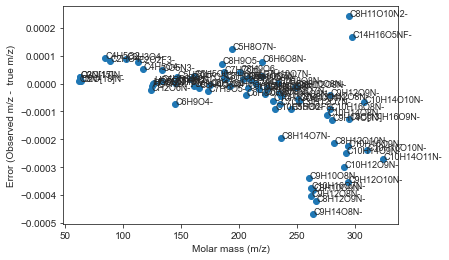

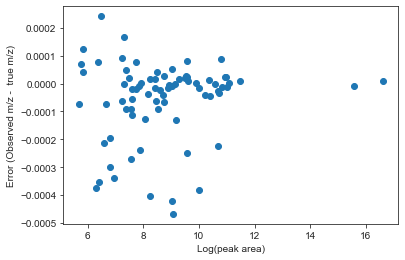

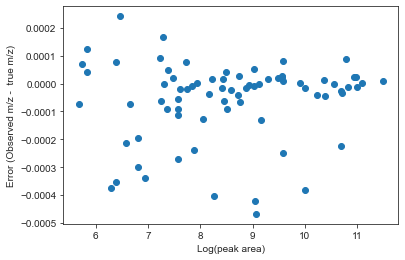

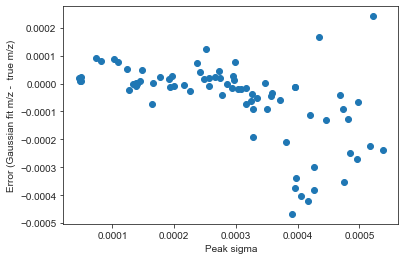

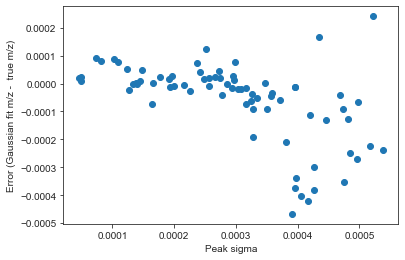

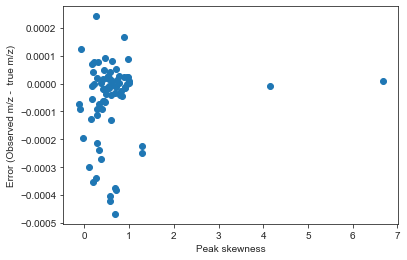

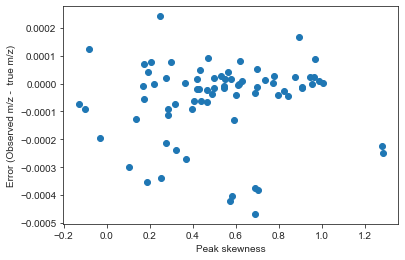


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


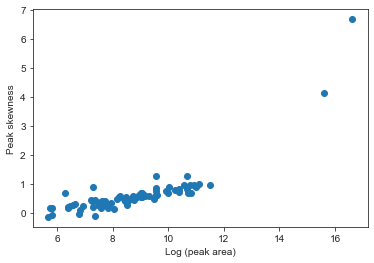

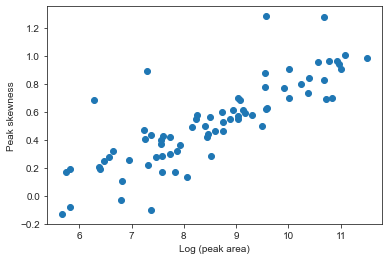

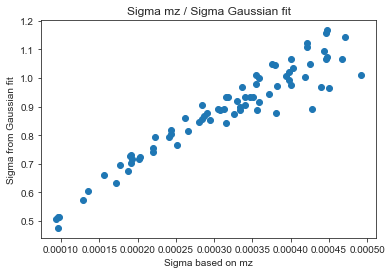

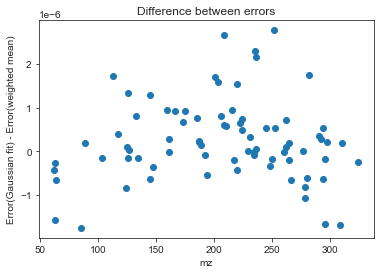

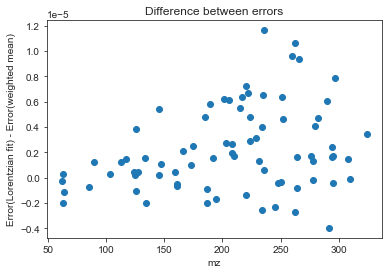

In [418]:
# Main program here

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spectrumNumber = 0         
data = readSpectrum(spectrumNumber)    # Read the nth file in the folder of spectra

# print(data[340:353])      # Just in case, if you want to print some values from the dataframe

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
# Rightmost value just above is the maximum alloved distance between true and observed peak

peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 9

peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #10
peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #11
peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #12  

peaklist['centerL'] = np.zeros(len(peaklist['mz']))   #13
peaklist['sigmaL']  = np.zeros(len(peaklist['mz']))   #14
peaklist['fwhmL'] = np.zeros(len(peaklist['mz']))   #15 
peaklist['heightG'] = np.zeros(len(peaklist['mz']))   #16
#peaklist['centerV'] = np.zeros(len(peaklist['mz']))   #16    # We skip using these
#peaklist['sigmaV']  = np.zeros(len(peaklist['mz']))   #17
#peaklist['fwhmV'] = np.zeros(len(peaklist['mz']))   #18 

addGaussians(peaklist)

#print(peaklist)

peaklist['error'] = peaklist['observed'] - peaklist['mz'] # 17
peaklist['errorG'] = peaklist['centerG'] - peaklist['mz'] # 18
peaklist['errorL'] = peaklist['centerL'] - peaklist['mz'] # 19

print(peaklist)

print("Number of actual recognized peaks: ",len(peaklist))
pd.set_option('display.max_rows', len(peaklist))
print(peaklist)   # Helps to find the number of the peak of interest
pd.reset_option('display.max_rows')




# Plot some interesting graphs

peaklist0 = peaklist.copy()
peaklist0 = peaklist0[peaklist0.loc[:,'idx'] != 1]     # Big NO3- peak
peaklist0 = peaklist0[peaklist0.loc[:,'idx'] != 29]    # Another big peak

xmz0 = peaklist0['mz']
ydiff0 = peaklist0['observed'] - peaklist0['mz'] 
names0 = peaklist0['formula']
pit0 = len(xmz0)

# This first one has formula annotations in the graph

xmz = peaklist['mz']
ydiff = peaklist['observed'] - peaklist['mz']
names = peaklist['formula']
pit = len(xmz)

y = ydiff
x = xmz
fig = plt.figure()
plt.scatter(x,y)

k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (m/z)")
plt.ylabel("Error (Observed m/z -  true m/z)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


# --------------------------------------------

logarea = np.log(peaklist['area'])
x = logarea
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed m/z -  true m/z)")
plt.show()


logarea0 = np.log(peaklist0['area'])
x = logarea0
y = ydiff0
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed m/z -  true m/z)")
plt.show()

# --------------------------------------------


#x =  1000000*peaklist['fwhmG'] / peaklist['heightG']
#y = peaklist['centerG'] - peaklist['mz']
#fig = plt.figure()
#plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

#plt.xlabel("1000000 * Peak fwhm / peak height")
#plt.ylabel("Error (Observed m/z -  true m/z)")
#plt.show()


#x = 1000000*peaklist0['fwhmG'] / peaklist0['heightG']
#y = peaklist0['centerG'] - peaklist0['mz']
#fig = plt.figure()
#plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#k = names
#ax1 = fig.add_subplot(111)
#for i,j,k in zip(x,y,k):
#    ax1.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

#plt.xlabel("1000000 * Peak fwhm / peak height")
#plt.ylabel("Error (Observed m/z -  true m/z)")
#plt.show()

# --------------------------------------------

x = peaklist['sigmaG']
y = peaklist['centerG'] - peaklist['mz']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak sigma")
plt.ylabel("Error (Gaussian fit m/z -  true m/z)")
plt.show()


x = peaklist0['sigmaG']
y = peaklist0['centerG'] - peaklist0['mz']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak sigma")
plt.ylabel("Error (Gaussian fit m/z -  true m/z)")
plt.show()

# --------------------------------------------

x = peaklist['skew']
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed m/z -  true m/z)")
plt.show()


x = peaklist0['skew']
y = ydiff0
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed m/z -  true m/z)")
plt.show()

# --------------------------------------------

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")

x = logarea
y = peaklist['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()


x = logarea0
y = peaklist0['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()

# --------------------------------------------

x = peaklist['sigma']
y = peaklist['sigmaG']/peaklist['sigma']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Sigma based on mz")
plt.ylabel("Sigma from Gaussian fit")
plt.title("Sigma mz / Sigma Gaussian fit")
plt.show()



x = peaklist['mz']
y = peaklist['errorG'] - peaklist['error']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(Gaussian fit) - Error(weighted mean)")
plt.title("Difference between errors")
plt.show()


x = peaklist['mz']
y = peaklist['errorL'] - peaklist['error']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(Lorentzian fit) - Error(weighted mean)")
plt.title("Difference between errors")
plt.show()
# KOj 19.3. and 31.3-6.4.

## plotPeak

Choose a peak index from the printed dataframe (above) and
plot the peak for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

            formula          mz    observed  peak          area      skew  \
1              O3N-   61.988366   61.988375     5  1.656485e+07  6.677467   
2          O3N[15]-   62.985401   62.985424    10  5.582311e+04  0.964888   
3         O2O[17]N-   62.992584   62.992606    11  1.414741e+04  0.875841   
4         O2O[18]N-   63.992613   63.992622    12  9.802709e+04  0.985926   
8           C4H5O2-   85.029503   85.029595    15  1.381071e+03  0.469239   
..              ...         ...         ...   ...           ...       ...   
254  C9C[13]H16O9N-  295.086410  295.086283    95  3.142938e+03  0.137284   
262     C14H16O5NF-  297.101799  297.101966    96  1.473922e+03  0.891939   
269     C10H14O10N-  308.062319  308.062254    97  6.353544e+03  0.464229   
274     C10H16O10N-  310.077969  310.077730    98  2.640839e+03  0.321048   
282     C10H14O11N-  324.057234  324.056963    99  1.937491e+03  0.370302   

        sigma  lefti  righti  idx     centerG    sigmaG     fwhmG     cente

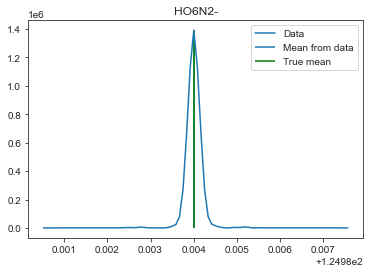

In [287]:
plotPeak(29,peaklist)  # 2, 8, 215, 269

## plotGaussian

Choose a peak index from the printed dataframe (above) and

plot the peak data and Gaussian fit data for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

Peak of interest:  C10H14O11N-
                x           y
index                        
0      324.055781    0.000000
1      324.056127   59.877319
2      324.056473  246.578652
3      324.056818  427.893512
4      324.057164  496.958821
5      324.057510  423.022883
6      324.057856  200.061728
7      324.058202   13.262555
8      324.058548    0.000000


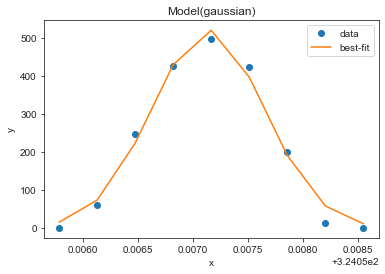

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 9
    # variables        = 3
    chi-square         = 4355.24293
    reduced chi-square = 725.873822
    Akaike info crit   = 61.6371998
    Bayesian info crit = 62.2288736
[[Variables]]
    amplitude:  0.66494495 +/- 0.02603781 (3.92%) (init = 0.5156003)
    center:     324.057135 +/- 2.2972e-05 (0.00%) (init = 324.0572)
    sigma:      5.0851e-04 +/- 2.3013e-05 (4.53%) (init = 0.0003458371)
    fwhm:       0.00119744 +/- 5.4191e-05 (4.53%) == '2.3548200*sigma'
    height:     521.675560 +/- 20.4300102 (3.92%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.578


In [350]:
plotGaussian(282, peaklist)


## readMultipleSpectra¶

A method to collect data from multiple spectra

First, it is necessary to establish a new dataframe for that

In [363]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
dfBase = pd.read_csv(ionFileName, sep=",")
dfSize = len(dfBase)
dfBase['idx'] = dfBase.index.to_numpy() 
dfBase['count'] = np.zeros(len(dfBase), dtype="uint32")
zeroBase = np.zeros(len(dfBase), dtype="uint32")
dfBase['sum'] = np.zeros(len(dfBase))
dfBase['new'] = np.zeros(len(dfBase))

#print(dfBase)

errors = dfBase.copy()
errorsG = dfBase.copy()
errorsL = dfBase.copy()
areas = dfBase.copy()

step = 11
count = 239      #239
colBase = "t-"
for i in range(count):
    n = i*step
    colName = colBase+str(i)
    
    data = readSpectrum(n)
    peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
    peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 9

    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #10
    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #11
    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #12  

    peaklist['centerL'] = np.zeros(len(peaklist['mz']))   #13
    peaklist['sigmaL']  = np.zeros(len(peaklist['mz']))   #14
    peaklist['fwhmL'] = np.zeros(len(peaklist['mz']))   #15  
    
    addGaussians(peaklist)

    peaklist['error'] = peaklist['observed'] - peaklist['mz'] # 16
    peaklist['errorG'] = peaklist['centerG'] - peaklist['mz'] # 17
    peaklist['errorL'] = peaklist['centerL'] - peaklist['mz'] # 18

# These need all be zeroed before the loop
    for k in range(len(dfBase)):
        errors.loc[k,'new']=0
        errorsG.loc[k,'new']=0
        errorsL.loc[k,'new']=0
        areas.loc[k,'new']=0
        
    for j in range(len(peaklist)):
#        zeroBase[peaklist.iloc[j,9]]=1
        errors.loc[peaklist.iloc[j,9],'count'] += 1
        errors.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,16]
        errorsG.loc[peaklist.iloc[j,9],'count'] += 1
        errorsG.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,17]  
        errorsL.loc[peaklist.iloc[j,9],'count'] += 1
        errorsL.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,18]
        areas.loc[peaklist.iloc[j,9],'count'] += 1
        areas.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,4]
        
    errors[colName] = errors['new']
    errors['sum'] += errors['new']
    errorsG[colName] = errorsG['new']
    errorsG['sum'] += errorsG['new']
    errorsL[colName] = errorsL['new']
    errorsL['sum'] += errorsL['new']
    areas[colName] = areas['new']
    areas['sum'] += areas['new']
    
print("DONE!")

0  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-06.csv
Shape:      1593, 2

11  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-58-06.csv
Shape:      1596, 2

22  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-00-07.csv
Shape:      1628, 2

33  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-02-08.csv
Shape:      1598, 2

44  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-04-09.csv
Shape:      1655, 2

55  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-06-09.csv
Shape:      1658, 2

66  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-08-10.csv
Shape:      1610, 2

77  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-10-11.csv
Shape:

715  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-07-11.csv
Shape:      1533, 2

726  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-09-12.csv
Shape:      1589, 2

737  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-11-12.csv
Shape:      1638, 2

748  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-13-13.csv
Shape:      1535, 2

759  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-15-14.csv
Shape:      1648, 2

770  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-17-14.csv
Shape:      1537, 2

781  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-19-15.csv
Shape:      1581, 2

792  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-21-16.c

1419  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-16-15.csv
Shape:      1630, 2

1430  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-18-15.csv
Shape:      1577, 2

1441  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-20-16.csv
Shape:      1583, 2

1452  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-22-17.csv
Shape:      1633, 2

1463  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-24-20.csv
Shape:      1594, 2

1474  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-26-20.csv
Shape:      1681, 2

1485  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-28-21.csv
Shape:      1674, 2

1496  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21

2123  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-25-17.csv
Shape:      1667, 2

2134  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-27-17.csv
Shape:      1589, 2

2145  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-29-18.csv
Shape:      1524, 2

2156  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-31-19.csv
Shape:      1606, 2

2167  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-33-19.csv
Shape:      1533, 2

2178  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-35-20.csv
Shape:      1759, 2

2189  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-37-21.csv
Shape:      1579, 2

2200  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23

In [436]:
errors2 = errors.copy()
errors2['ave'] = errors2['sum']/errors2['count']
errorsG2 = errorsG.copy()
errorsG2['ave'] = errorsG2['sum']/errorsG2['count']
errorsL2 = errorsL.copy()
errorsL2['ave'] = errorsL2['sum']/errorsL2['count']
areas2 = areas.copy()
areas2['ave'] = areas2['sum']/areas2['count']


print("------ --------------- -----")
areas2 = areas2[areas2.loc[:,'idx'] != 1]     # Big NO3- peak removed
areas2 = areas2[areas2.loc[:,'idx'] != 29]    # Another big peak removed
errors2 = errors2[errors2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errors2 = errors2[errors2.loc[:,'idx'] != 29]    # Another big peak removed
errorsG2 = errorsG2[errorsG2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errorsG2 = errorsG2[errorsG2.loc[:,'idx'] != 29]    # Another big peak removed
errorsL2 = errorsL2[errorsL2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errorsL2 = errorsL2[errorsL2.loc[:,'idx'] != 29]    # Another big peak removed
print(len(errors2))
dropLimit = 120                                                    #  <===  OBS OBS OBS !!!!  (191 is half)
errors2 = errors2[errors.loc[:,'count'] > dropLimit]
errorsG2 = errorsG2[errorsG2.loc[:,'count'] > dropLimit]
errorsL2 = errorsL2[errorsL2.loc[:,'count'] > dropLimit]
areas2 = areas2[areas2.loc[:,'count'] > dropLimit]
print(len(errors2))

# Removing all values with NaN (that is, ion was not detected)
#errors2 = errors2.dropna()
#errorsG2 = errorsG2.dropna()
#errorsL2 = errorsL2.dropna()
#areas2 = areas2.dropna()


print(errors2)
print(errorsG2)
print(errorsL2)
print(areas2[:10])


print("-----------")
print(errorsG2.loc[:,'ave']-errors2.loc[:,'ave'])
print(errorsL2.loc[:,'ave']-errors2.loc[:,'ave'])

------ --------------- -----
290
199
             formula          mz  idx  count       sum       new       t-0  \
0            C2H3O2-   59.013853    0     19 -0.000508  0.000000  0.000000   
2           O3N[15]-   62.985401    2    239  0.005742  0.000023  0.000023   
3          O2O[17]N-   62.992584    3    239  0.005040  0.000024  0.000022   
4          O2O[18]N-   63.992613    4    239  0.002641  0.000010  0.000009   
6            C3H5O2-   73.029503    6     14  0.000327  0.000000  0.000000   
..               ...         ...  ...    ...       ...       ...       ...   
285  C9C[13]H14O11N-  325.060589  285      1 -0.000085  0.000000  0.000000   
287      C10H16O11N-  326.072884  287      1 -0.000343  0.000000  0.000000   
289      C12H18O10N-  336.093619  289     13 -0.002436  0.000000  0.000000   
290      C11H16O11N-  338.072884  290      2 -0.000498  0.000000  0.000000   
291     C10H15O11N2-  339.068133  291      1  0.000077  0.000000  0.000000   

          t-1       t-2   

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [389]:
print(errors2[50:])

            formula          mz  idx  count       sum       new       t-0  \
211       C9H12O8N-  262.056840  211    239 -0.094373 -0.000420 -0.000404   
214       C8H10O9N-  264.036104  214    239 -0.096780 -0.000373 -0.000381   
215       C9H14O8N-  264.072490  215    239 -0.097965 -0.000454 -0.000467   
220       C8H12O9N-  266.051755  220    239 -0.102003 -0.000443 -0.000421   
225      C10H14O8N-  276.072490  225    221 -0.018588 -0.000090 -0.000115   
228       C9H12O9N-  278.051755  228    239 -0.023796 -0.000053 -0.000041   
229      C10H16O8N-  278.088140  229    236 -0.025777 -0.000123 -0.000091   
236       C9H14O9N-  280.067405  236    239 -0.029764 -0.000048 -0.000131   
248      C10H14O9N-  292.067405  248    239 -0.053444 -0.000214 -0.000250   
252      C10H16O9N-  294.083055  252    239 -0.052286 -0.000195 -0.000225   
253     C8H11O10N2-  295.041918  253    139  0.001023  0.000019  0.000241   
254  C9C[13]H16O9N-  295.086410  254    199  0.000505  0.000055 -0.000126   

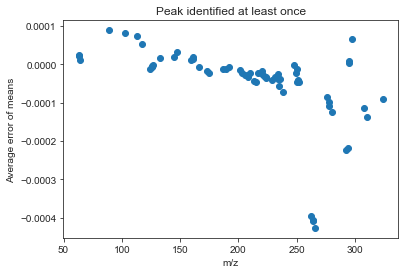

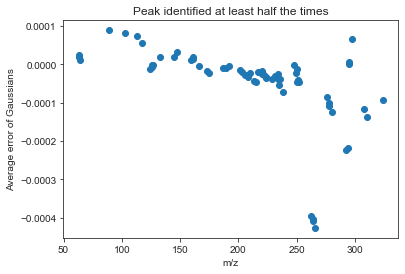

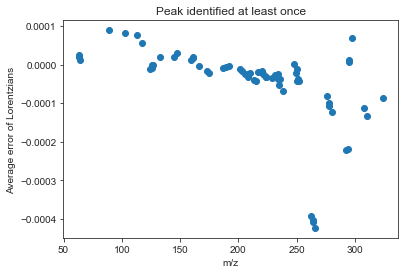

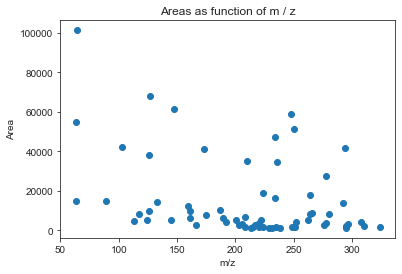

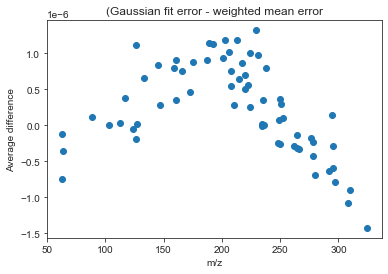

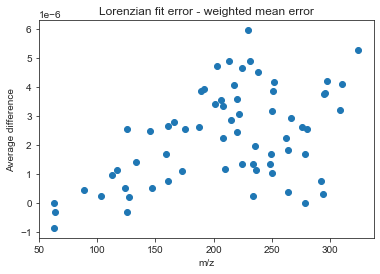

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


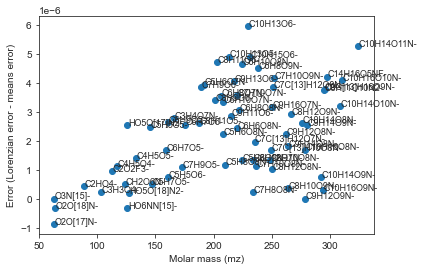

            formula          mz  idx  count
2          O3N[15]-   62.985401    2    239
3         O2O[17]N-   62.992584    3    239
4         O2O[18]N-   63.992613    4    239
9            C2HO4-   88.988032    9    239
15          C3H3O4-  103.003682   15    239
..              ...         ...  ...    ...
254  C9C[13]H16O9N-  295.086410  254    199
262     C14H16O5NF-  297.101799  262    237
269     C10H14O10N-  308.062319  269    238
274     C10H16O10N-  310.077969  274    218
282     C10H14O11N-  324.057234  282    174

[66 rows x 4 columns]


In [392]:
x = errors2['mz']
y = errors2['ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of means")
plt.title("Peak identified at least once")
plt.show()


x = errorsG2['mz']
y = errorsG2['ave']
fig = plt.figure()
#plt.scatter(x,y, color = "red")
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of Gaussians")
plt.title("Peak identified at least half the times")
plt.show()


x = errorsL2['mz']
y = errorsL2['ave']
fig = plt.figure()
#plt.scatter(x,y,color = "green")
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of Lorentzians")
plt.title("Peak identified at least once")
plt.show()

x = areas2['mz']
y = areas2['ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Area")
plt.title("Areas as function of m / z")
plt.show()




x = errorsG2['mz']
y = errorsG2.loc[:,'ave']-errors2.loc[:,'ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average difference")
plt.title("(Gaussian fit error - weighted mean error")
plt.show()


x = errorsL2['mz']
y = errorsL2.loc[:,'ave']-errors2.loc[:,'ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average difference")
plt.title("Lorenzian fit error - weighted mean error")
plt.show()


#  Here use pyplot to annotate

xmz = errorsL2['mz']
ydiff = errorsL2.loc[:,'ave']-errors2.loc[:,'ave'] 
names = errorsL2['formula']
pit = len(xmz)

y = ydiff
x = xmz
fig = plt.figure()
plt.scatter(x,y)

k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Lorenzian error - means error)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()

print(errors2.iloc[:,0:4])

## Plot ion error as function of time

Put the ion number into variable nm  e.g. 2 (+) or  25 (-)

Note: there may be no recordings on that ion number.

Ion 1 (NO3-) givess some single high error values!

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


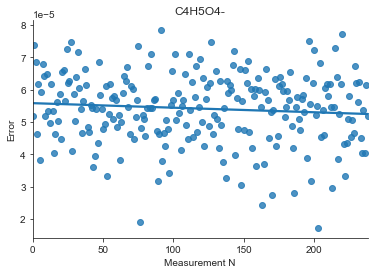

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


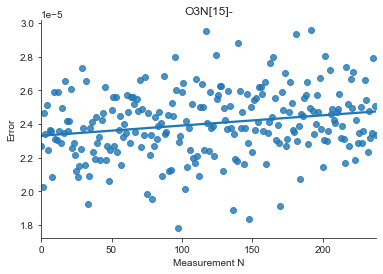

In [367]:
import seaborn as sns

nm = 25
data = errors[errors['idx']==nm].to_numpy().copy()
data = data[0]
sCount = 239   # How many spectra 239

x = np.arange(sCount)
y = data[6:len(data)]

sns.set_style('ticks')
sns.regplot(x, y, ci=None)
sns.despine()
plt.xlabel('Measurement N')
plt.ylabel('Error')
plt.title(data[0])

plt.show()   # with this, you get 2 separate graphs

nm = 2
data = errors[errors['idx']==nm].to_numpy().copy()
data = data[0]

x = np.arange(sCount)
y = data[6:len(data)]

sns.set_style('ticks')
sns.regplot(x, y, ci=None)
sns.despine()
plt.xlabel('Measurement N')
plt.ylabel('Error')
plt.title(data[0])

plt.show()


In [272]:
errors.to_csv('errors.csv')
errors2.to_csv('errors2.csv')
errorsG.to_csv('errorsG.csv')
errorsG2.to_csv('errorsG2.csv')
errorsL.to_csv('errorsL.csv')
errorsL2.to_csv('errorsL2.csv')
areas.to_csv('areas.csv')
areas2.to_csv('areas2.csv')

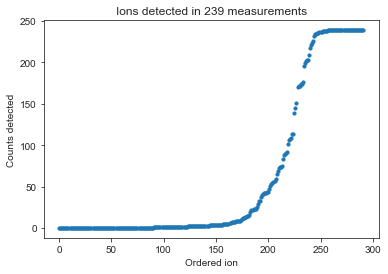

201
35
292
              formula          mz  count           ave
149          C5H6O9N-  224.004804    239 -3.229969e-05
33        HO5O[18]N2-  126.988256    239 -1.184298e-06
252        C10H16O9N-  294.083055    239 -2.186299e-04
90           C8H11O5-  187.061197    239 -1.037601e-05
248        C10H14O9N-  292.067405    239 -2.242422e-04
191         C8H10O8N-  248.041190    239 -1.016353e-06
48            C5H5O5-  145.014247    239  1.875002e-05
236         C9H14O9N-  280.067405    239 -1.252307e-04
51            C5H7O5-  147.029897    239  3.122770e-05
119          C5H6O8N-  208.009890    239 -3.347248e-05
197         C8H12O8N-  250.056840    239 -1.323055e-05
59            C6H7O5-  159.029897    239  1.090542e-05
228         C9H12O9N-  278.051755    239 -9.978926e-05
62            C5H5O6-  161.009161    239  1.907177e-05
63            C6H9O5-  161.045547    239  1.476547e-05
220         C8H12O9N-  266.051755    239 -4.271191e-04
74            C7H9O5-  173.045547    239 -1.825400e-05

In [437]:
list = errors.copy()

list.sort_values("count", inplace=True)

#list
ccc = list['count'].to_numpy()
ccc
x = np.arange(len(ccc))
plt.scatter(x,ccc, s=10)
plt.xlabel('Ordered ion')
plt.ylabel('Counts detected')
plt.title('Ions detected in 239 measurements')
plt.show()

xxx = list[list['count']>0]
print(len(xxx))
yyy = list[list['count']==239]
print(len(yyy))
print(len(errors))

list2 = errorsG2.copy()
list2.sort_values("count", ascending=False, inplace=True)

list3 = list2.copy()

list3 = list2[['formula', 'mz', 'count', 'ave']].copy()

pd.set_option("display.max_rows", None)
print(list3)
pd.set_option("display.max_rows", 10)
print(list3)